# Exploratory Text Classification and Topic Modelling

- We begin with a dataset from: https://www.kaggle.com/datasets/shivamkushwaha/bbc-full-text-document-classification
- which consists of over 2000 BBC text articles, categorised into the following categories: 'business', 'entertainment', 'politics', 'sport', 'tech'
- We read in the dataset into a dataframe called 'all' that also has a numeric label 0-4 mapped for the categories.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import os
import re
import warnings
warnings.filterwarnings('ignore')

sns.set()
sns.set_style("darkgrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

In [2]:
### READ FOLDER CONTENTS
path = './data/bbc'
folders = os.listdir(path)
folders = [f for f in folders if os.path.isdir(os.path.join(path, f))]
folderpaths = [os.path.join(path, f) for f in folders]

### CREATE LIST OF ALL FILENAMES
files_list = []
for fpath in folderpaths:
    fns = os.listdir(fpath)
    fns = [os.path.join(fpath,f) for f in fns if os.path.isfile(os.path.join(fpath, f))]
    files_list.append(fns)

### READ IN ALL FILES
all_articles = []
for i, folder in enumerate(files_list):
    articles_in_folder = []
    for fn in folder:
        f = open(fn)
        article = f.read()
        articles_in_folder.append((article, i))
    all_articles.append(articles_in_folder)

### COMBINE ALL ARTICLES IN EACH CATEGORY INTO 1 DATAFRAME.
business      = pd.DataFrame(all_articles[0], columns=['text','label'])
entertainment = pd.DataFrame(all_articles[1], columns=['text','label'])
politics      = pd.DataFrame(all_articles[2], columns=['text','label'])
sport         = pd.DataFrame(all_articles[3], columns=['text','label'])
tech          = pd.DataFrame(all_articles[4], columns=['text','label'])
all           = pd.concat([business,entertainment,politics,sport,tech])

all.head()

,text,label
0,Ad sales boost Time Warner profit\n\nQuarterly...,0
1,Dollar gains on Greenspan speech\n\nThe dollar...,0
2,Yukos unit buyer faces loan claim\n\nThe owner...,0
3,High fuel prices hit BA's profits\n\nBritish A...,0
4,Pernod takeover talk lifts Domecq\n\nShares in...,0


# Preprocess and Vectorize Text

In [3]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

##? PREPROCESSING: TOKENIZE, STOPWORDS, LEMMATIZE, REGEX FILTER
sw_eng = stopwords.words('english')
charfilter = re.compile('[a-zA-Z]{3,}') # at least 3 letter words

def simple_tokenizer(text):
    words = nltk.word_tokenize(text.lower())
    tokens = (list(map(lambda token: nltk.WordNetLemmatizer().lemmatize(token), words)))
    words = [w for w in words if w not in sw_eng]
    ntokens = list(filter(lambda token : charfilter.match(token),tokens))
    return ntokens


##? COUNT VECTORIZE DATASET INTO SPARSE VECTOR BAG OF WORDS
##? (LDA HAS BUILT-IN TF-IDF, SO WE WILL USE COUNTVECTORIZER)
vect = CountVectorizer(tokenizer = simple_tokenizer, strip_accents='unicode', min_df=20, max_df=0.3, ngram_range=(1,3))
X = vect.fit_transform(all['text'])
print('NUM OF FEATURES: {}\n'.format(len(vect.get_feature_names_out())))




##? REVIEW WORDS WITH LOWEST/HIGHEST COUNTS
featurecounts = pd.DataFrame({
    'name'  : vect.get_feature_names_out(),
    'counts' : X.max(0).toarray()[0],
}).sort_values('counts', ascending=False)
print("High counts:")
display(featurecounts.head(10))
print("Low counts:")
display(featurecounts.tail(10))

NUM OF FEATURES: 5224

High counts:


,name,counts
3753,song,81
2667,music,69
4917,wage,61
537,best,56
3426,roddick,53
2582,minimum,47
1731,game,44
2925,party,41
2082,increase,38
1811,government,34


Low counts:


,name,counts
3813,stage the,1
1631,for next,1
1632,for one,1
2956,people use,1
2957,people want,1
849,closing,1
1633,for other,1
2960,people who are,1
843,clive woodward,1
2612,money the,1


# For a simple classifier task, we could use PCA to reduce the dimensionality 
- and train a classifier with reduced features, for faster train time.
- For a start, we could try the minimum dimensions that captured at least half the total explained variance, and see the model's performance.
- (did not attempt classification in this notebook)

NUM OF FEATURES: 11592



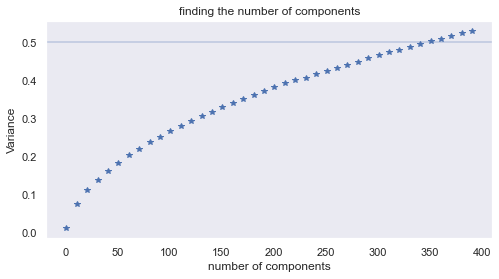

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

##? IN THIS CASE, TF-IDF IS A BETTER VECTORIZATION TO USE RATHER THAN THE SIMPLER COUNT VECTORIZATION.
vect_tfidf = TfidfVectorizer(tokenizer = simple_tokenizer, strip_accents='unicode', min_df=10, max_df=0.3, ngram_range=(1,3))
X_tfidf = vect_tfidf.fit_transform(all['text'])
print('NUM OF FEATURES: {}\n'.format(len(vect_tfidf.get_feature_names_out())))

##? FIND THE NUMBER OF COMPONENTS WHICH SATISFY AT LEAST HALF THE VARIANCE
pc_range = range(1,400,10)
variances = []
for i in pc_range:
    pca = PCA(i)
    pca.fit(X_tfidf.toarray())
    variances.append(pca.explained_variance_ratio_.sum())

##? PLOT CUMULATIVE EXPLAINED VARIANCE:
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 4))
plt.grid()
plt.plot(pc_range, variances, 'b*')
plt.axhline(0.5, alpha=0.3)
plt.xlabel('number of components')
plt.ylabel('Variance')
plt.title('finding the number of components')
plt.show()

# PCA for visualisation of vectorized categories (optional)

<AxesSubplot:>

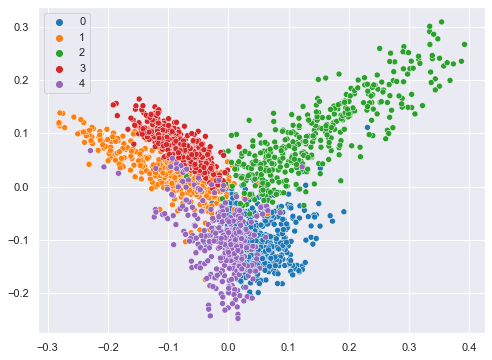

In [22]:
from sklearn.decomposition import PCA

###? CREATE 2D PRINCIPAL COMPONENTS FOR EASE OF VISUALISING DATASET
pca = PCA(2, random_state=0)
X_pcavis = pca.fit_transform(X_tfidf.toarray())
y = all['label'].tolist()

import seaborn as sns
plt.figure(figsize = (8, 6))
sns.scatterplot(X_pcavis[:, 0], X_pcavis[:, 1], hue=y, palette='tab10')

# K-means clustering (attempt at finding optimal n_topics)

- Technically, the above assigned 5 categories is also an arbitrary number, as there could be further subcategories in each. e.g. in sports, baseball vs soccer.
- If we were looking at this collection of texts as unknown, using the 'elbow method' we could try to find an optimal number of clusters.
- However, for this exercise, we will just plug in n_clusters=5 and see how well k-Means is able to perform. Good performance may also suggest that the clusters are relatively spherical
- Also, we could consider other clustering methods such as DBSCAN or Gaussian Mixture Model BIC scores to find optimal n_clusters, since clusters won't necessarily be spherical. 

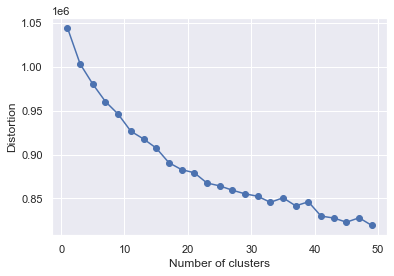

In [30]:
from sklearn.cluster import KMeans, MiniBatchKMeans

###? CALCULATE DISTORTIONS/INERTIAS FOR A RANGE OF N_CLUSTERS
n_cluster_range = range(1,50,2)
distortions = []
for i in n_cluster_range:
    km = KMeans(n_clusters=i, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)

###? PLOT DISTORTIONS
plt.plot(n_cluster_range, distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

<AxesSubplot:>

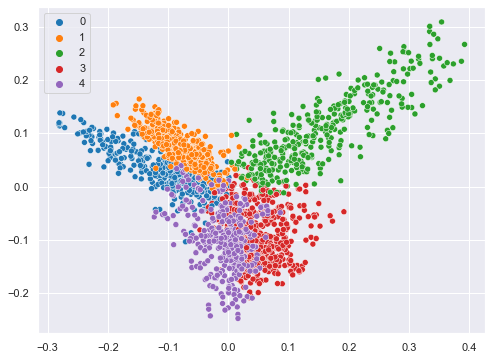

In [41]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

###? KMEANS K=5
kmeans = KMeans(5, max_iter=100, random_state=0)
pred_kmeans = kmeans.fit_predict(X_tfidf)

plt.figure(figsize = (8, 6))
sns.scatterplot(X_pcavis[:, 0], X_pcavis[:, 1], hue=pred_kmeans, palette='tab10')


#### Since k-Means was unsupervised, cluster labels were assigned arbitrarily. Let's remap the labels based on visual comparison and check the accuracy score.

In [31]:
import numpy as np
import uuid

def vector_map(data, _map):
    # from: https://gist.github.com/legaultmarc/92c4065e157eb93d57a5
    """Remaps numeric values in a data vector.
    :param data: A numpy array of integer or float dtype.
    :param _map: A list of tuple representing the mappings.
                 Alternatively, a dict can be provided directly.
                 ``[(2, 1), (1, 0), (3, -10)]`` would transform all the
                 ``2 -> 1``, ``1 -> 0`` and ``3 -> -10``.
    :returns: A remapped numpy array.
    The strategy used to avoid collisions when sequentially remapping is to
    use transitive mapping. This means that the mapping is done in two steps:
    A mapping to a unique (random) value and then a subsequent mapping to the
    target value.
    This strategy is only used if there are collisions.
    >>> import numpy as np
    >>> from remap import vector_map
    >>> a = np.array([-9, 2, 2, 1, 2, 1, -9, 2])
    >>> vector_map(a, [(-9, np.nan), (2, 1.0), (1, 0.0)])
    array([ nan,   1.,   1.,   0.,   1.,   0.,  nan,   1.])
    Type consistency is annoying, but it is safer this way as there is no risk
    of weird comparisons or type mistakes.
    """

    if type(_map) is not dict:
        _map = dict(_map)

    # Check the dtype of the vector and the map.
    if np.issubdtype(data.dtype, int):
        source_dtype = int
    elif np.issubdtype(data.dtype, float):
        source_dtype = float
    else:
        raise TypeError("Invalid dtype: '{}'. This function only allows "
                        "int or float vectors.".format(data.dtype))

    keys = set(_map.keys())
    targets = set(_map.values())

    # Infer the target dtype.
    target_dtype = set([float if np.isnan(t) else type(t) for t in targets])

    if len(target_dtype) != 1:
        raise TypeError("Ambiguous target dtype. Make sure that the provided "
                        "mapper uses consistent type for the second element "
                        "of the tuples.")
    target_dtype = target_dtype.pop()

    if target_dtype is int and source_dtype is float:
        raise TypeError("Remapping floats to integers is not possible "
                        "because of lost of data in type cast (this can "
                        "be fixed by using floats as the target values).")

    out = data.astype(target_dtype)

    for key, target in _map.items():
        if np.isnan(key):
            raise TypeError("Can't use NaNs as mapping keys.")

        if target in keys:
            # There will be a collision, so we need to use the transitive
            # mapping.
            transitive_key = np.random.randint(1000,2147483648) # hash(str(uuid.uuid4()))
            out[data == key] = transitive_key
            out[out == transitive_key] = target
        else:
            out[data == key] = target

    return out

In [42]:
mapping = {
    0:1,
    1:3,
    2:2,
    3:0,
    4:4,
}

pred_kmeans_remapped = vector_map(pred_kmeans, mapping)
# print(accuracy_score(y_train, pred_kmeans))
print('ACCURACY SCORE: {:.4f}'.format(accuracy_score(y, pred_kmeans_remapped)))


ACCURACY SCORE: 0.9456


- Not bad for k-Means.

# LDA Topic Modelling with gensim

- Attempt LDA modelling with gensim and sklearn for comparison. sklearn seems to train faster and good for quick exploration of topics, but gensim has more comprehensive features.

In [43]:

###? GENSIM LDA MODEL

# from gensim import corpora, models
import gensim

###? GENSIM PREP:
# CONVERT VECT SPARSE MATRIX INTO GENSIM CORPUS
corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)
# CREATE ID-WORD MAP
id_map = dict((v, k) for k, v in vect.vocabulary_.items())


###? TRAIN GENSIM LDA MODEL TO ESTIMATE LDA PARAMS ON CORPUS
gensimlda = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=5, id2word=id_map, passes=140, decay=0.7, random_state=0)


###? GET FITTED TOPICS
gensimlda_topics_ = gensimlda.print_topics(num_topics=-1, num_words=40)


###? REMOVE THE PROBABILITY VALUES AND ONLY RETURN TOPIC WORDS
def clean_topics(topics):
    alltopicwords = []
    for i in range(len(topics)):
        sentence = str(topics[i][1])
        topictuples = sentence.split(' + ')
        currenttopicwords = []
        for topictuple in topictuples:
            if (re.search(r'\"(?:\w+)\"', topictuple)):
                word = re.search(r'\"(?P<a>\w+)\"', topictuple)[1]
                currenttopicwords.append(word)
        alltopicwords.append(currenttopicwords)
    return alltopicwords

###? PRINT TOPIC TOP KEYWORDS
alltopicwords = clean_topics(gensimlda_topics_)
for i, topic in enumerate(alltopicwords):
    print('TOPIC {} : {}'.format(i, ' '.join(topic)))

TOPIC 0 : she government her against minister told labour party what should election back law world win right before him did blair england any only game you plan very them public week bbc just made european get being tory then take
TOPIC 1 : game you service world broadband get mobile like video phone gaming what such your technology play just them console way how radio online take want only player because around well going programme work much these need may mean
TOPIC 2 : film market sale million company best award price firm growth figure share record bank economy china while number analyst top country month show world rate director economic report according star business rise three dollar oil
TOPIC 3 : music mobile technology digital device consumer phone player apple gadget medium camera dvd show sony service content market image video firm what them portable ipod use mini format computer way such product home want chip picture drive film like
TOPIC 4 : user software net firm syste

# LDA Topic Modelling with sklearn

In [44]:
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 5

##? TRAIN SKLEARN LDA MODEL
sklearnlda = LatentDirichletAllocation(n_components=n_topics,random_state=0).fit(X)

In [45]:

###? PRINT TOPIC TOP KEYWORDS
n_words = 40
feature_names = vect.get_feature_names()

topic_list = []
for topic_idx, topic in enumerate(sklearnlda.components_):
    top_n = [feature_names[i]
              for i in topic.argsort()
               [-n_words:]][::-1]
    
    top_features = ' '.join(top_n)
    
    topic_list.append(f"topic_{'_'.join(top_n[:3])}") 

    print(f"TOPIC {topic_idx}: {top_features}")
    
topic_result = sklearnlda.transform(X)
all['topic']  = topic_result.argmax(axis=1)

TOPIC 0: government labour party election minister blair the government tory should plan tax told brown public law what lord issue country leader howard being prime right prime minister bbc any you secretary britain the tory home general chancellor against claim campaign only case conservative
TOPIC 1: game player england win you against world club back play team match just him the game side before second very cup wale ireland good get champion did set final six injury then coach only take the first season them minute what three
TOPIC 2: market sale bank price growth economy company share rate month economic china country oil dollar analyst figure rise however world profit firm business euro cost expected while from the the world deal may million india job stock investment chief more than december the company
TOPIC 3: film she best her award show music star won top song number band actor you the film british album director the best bbc prize including while chart record three movie hit

# Prediction of topics with a new document

In [47]:
testdoc = ["""
Apple’s iPhone 14 launch event is just days away, and it’s expected to showcase a range of new devices — not just a new iPhone. We’re also on the lookout for three (yes, we said three) new Apple Watch models and even a refreshed pair of AirPods Pro earbuds. Apple’s holding a small in-person event at its Apple Park campus and will stream the show online, similar to what it did with WWDC in June. Here’s what we might see at Apple’s hardware-heavy event, which is slated for September 7th, 2022, at 1PM ET. The iPhone 14 Pro and Pro Max get some major upgrades. Apple will, of course, reveal the brand new iPhone 14 in September, but the standard model likely won’t be the star of the show. The iPhone 14 Pro and Pro Max are expected to carry the bulk of the new and exciting features. 
There are three big features expected in the 14 Pro and Pro Max: a customizable always-on display (a feature Android phones have had for years); a 48-megapixel rear camera with a larger sensor; and a screen that gets rid of the notch in favor of smaller camera cutouts.

Speaking of the cutouts, a report from MacRumors indicates the camera and speaker will have separate cutouts when the screen’s turned off but will form one long pill shape when it’s powered on. A tipster told 9to5Mac that Apple will use the extra space between the two cutouts to more prominently display the privacy indicators for the camera and microphone, which users may be able to tap into for more information about what’s currently accessing them. 9to5Mac also said Apple may optimize its Camera app for its Pro devices by shifting some of its controls, like the flash and autofocus button to the top of the screen, with others housed directly beneath the cutout.

The phone should also get an upgraded A16 processing chip and potentially have two new colors: blue and deep purple. It’s also rumored to support a faster 30W charger (but the phone itself probably won’t come with USB-C just yet), as well as start with 256GB of storage, a jump from the 128GB floor that previous Pro and Pro Max models have. The Pro line is also rumored to have slimmer bezels and bigger batteries. It’s a solid list of new features that Apple may use to justify a rumored price hike for its higher-end iPhones.

However, it doesn’t seem like the standard version of the iPhone 14 will come with many major changes. The biggest update to the non-Pro model is expected to be the introduction of a larger 6.7-inch display in the iPhone 14 Max — if it’s even called that. Purported phone packaging from Apple’s factory indicates that the company might be planning to swap the “Max” branding on the standard iPhone model for “Plus,” a moniker Apple hasn’t used since the iPhone 8 Plus.
"""]

testvec = vect.transform(testdoc)
sklearnlda.transform(testvec)

array([[0.00, 0.00, 0.08, 0.18, 0.74]])

# Wordcloud visualisations of topic keywords

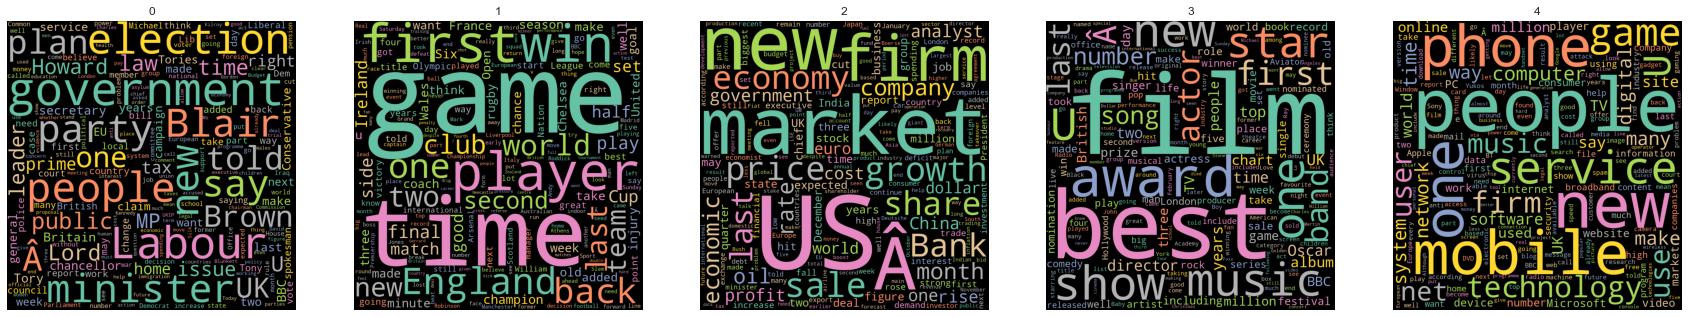

In [50]:
# !pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

###? ADDED STOPWORDS, AS THESE WORDS WERE OVERLY PROMINENT IN VIS
sw_additional = ['said','will','mr', 'year'] 
sw = set(list(STOPWORDS) + list(sw_eng) + list(sw_additional)) 

###? PLOT TOPIC TOP KEYWORDS
fig = plt.figure(figsize=(30,25))
for i in range(n_topics):
    ax = fig.add_subplot(1,n_topics,i+1)
    topic = i
    text = ' '.join(all.loc[all['topic']==i,'text'].values)
    wc = WordCloud(width=1000, 
                   height=1000, 
                   random_state=1, 
                   background_color='Black',
                   colormap='Set2',
                   collocations=False, stopwords=sw,
                   ).generate(text)
    ax.imshow(wc)
    ax.set_title(topic)
    ax.axis("off");